In [2]:
import sys
sys.path.append('eval/')
sys.path.append('models/')
sys.path.append('process_data/')

import glob
import itertools
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle as pkl
import torch
from scipy.stats import poisson, norm, laplace, lognorm

from class_mve_loss import MVELoss

import util_eval
import util_gcnn, util_gat
import util_plot
import util_results

from util_data import dotdict

from default_parameters import *
from setup import * 

%load_ext autoreload
%autoreload 2
plt.rcParams.update({'font.size': 9})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
colors = {"laplace":"cornflowerblue", "tnorm":"mediumseagreen", "norm":"salmon", "poisson":"plum", 
          "norm_ens": "peru", "norm_homo":"gray"}
label = {"laplace":"LAP", "tnorm":"TG", "norm":"HetG", "poisson":"Pois", 
          "norm_ens": "GEns", "norm_homo":"HomoG"}

In [4]:
project_dir = "/home/jtl/Dropbox (MIT)/project_uncertainty_quantification/"

args = dotdict({"Lookback":4,
       "Dist":"norm",
       "MeanOnly":False,
       "ModelNumberStart":-1,
       "ModelNumberEnd":0,
       "Adj":["func","euc","con","net"],
       "Save":False,
       "PredictHorizon":1,
       "TimeSize":4,
       "Difference":True,
       "LossFunc":"mve",
       "Homoskedastic":False,
       "TrainExtent":"downtown",
       "Epoch":501,
       "LearningRate":0.001,
       "IncludeSpatial":False,
       "Bootstrap":False})

max_lookback = 6


if args.ModelNumberStart == -1:
    run_all = True
else:
    run_all = False

predict_hzn = args.PredictHorizon
time_size = args.TimeSize
difference = args.Difference
adj_type = args.Adj
train_extent = args.TrainExtent
out_folder = args.OutFolder
lookback = 4
adj_type = ["func","euc","con","net"]

downtown_stations = pd.read_csv(project_dir+"data/data_processed/downtown_stations.csv")
criterion = MVELoss(dist=args.Dist)
device = torch.device("cpu")

z=1.96

In [5]:
out_folder = "220405"
result_file = "results.csv"
period = 'before'
args.Model = "GCN"

# df1 = pd.read_csv(project_dir+"results/"+out_folder+"_"+period+"/"+result_file)


In [6]:
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, period, predict_hzn, time_size, difference, max_lookback, lookback)


trainloader, trainloader_test, testloader, adj_torch, spatial_torch, y_train_eval, y_test_eval = \
    util_gcnn.prepare_for_torch(device, train_extent, data, adj, spatial, downtown_filter, adj_type, val=False)
y_test_eval = np.squeeze(y_test_eval)

(_, _, _, n_modes) = data['x'][0].shape
n_stations = adj_torch.shape[0]
n_time = 96 // time_size - 7

In [11]:
# cal_error = []
# model_number = []
# lb = []
# dst = []

# for ii, lookback, dist in zip(df1['Model'], df1['Lookback'], df1['Distribution']):

# Before, GCN
# iis = [16, 29, 16, 15, 21]
# lookbacks = [4, 6, 6, 4, 4]
# dists = ['norm_homo', 'norm','tnorm','poisson','laplace']

# After, GCN
# iis = [33, 60, 19, 23, 21]
# lookbacks = [6, 2, 6, 2, 6]
# dists = ['norm_homo', 'norm','tnorm','poisson','laplace']

# Before, GAT
# iis = [73, 12, 110, 15, 49]
# lookbacks = [4, 6, 4, 4, 4]
# dists = ['norm_homo', 'norm','tnorm','poisson','laplace']

# After, GAT
# iis = [68, 50, 35, 63, 19]
# lookbacks = [6, 4, 4, 4, 4]
# dists = ['norm_homo', 'norm','tnorm','poisson','laplace']

norm
tensor([[[[ -18.0000,   11.0000,  -33.8972],
          [  46.0000,  -66.0000,  -48.1640],
          [  -4.0000,   12.0000,  -32.4942],
          ...,
          [  16.0000,   17.0000,  -28.4474],
          [  -7.0000,    1.0000,  -10.5867],
          [ -41.0000,   44.0000,  -18.4405]],

         [[  -1.0000,   -2.0000,  -23.0345],
          [ 194.0000,   68.0000,  -48.6503],
          [  -4.0000,  -33.0000,  -20.6619],
          ...,
          [ -51.0000,  -36.0000,  -13.7503],
          [ -46.0000,   -1.0000,  -12.8353],
          [  11.0000,   17.0000,  -15.9053]],

         [[  26.0000,   41.0000,  -73.9089],
          [  42.0000,  -96.0000, -106.7668],
          [ -60.0000,   20.0000,  -69.4271],
          ...,
          [  -3.0000,   15.0000,  -56.8064],
          [ -31.0000,  -24.0000,  -20.9393],
          [   9.0000, -174.0000,  -59.6116]],

         [[  35.0000,  -60.0000,  -77.4715],
          [  16.0000,  258.0000, -136.7518],
          [ -51.0000,  -78.0000,  -73.6399],

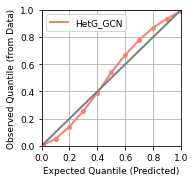

In [19]:
fig, ax = plt.subplots(1,1,figsize=(2.5, 2.5))

# iis = [33, 60, 19, 23, 21]
# lookbacks = [6, 2, 6, 2, 6]
# dists = ['norm_homo', 'norm','tnorm','poisson','laplace']

# iis = [29, 16, 15, 21]
# lookbacks = [6, 6, 4, 4]
# dists = ['norm','tnorm','poisson','laplace']

iis = [29]
lookbacks = [6]
dists = ['norm']

for ii, lookback, dist in zip(iis, lookbacks, dists):
    print(dist)
    
    criterion = MVELoss(dist)
    
    if (dist == 'norm_homo'):
        meanonly=True
    elif dist == 'poisson':
        meanonly=True
    else:
        meanonly=False

    if dist == 'norm_homo':
        homo = True
    else:
        homo = False

    if args.Model == 'GCN':
        save_dir = project_dir+"models/"+out_folder+"_"+period+"_"+dist+"/"
    else:
        save_dir = project_dir+"models/"+out_folder+"_"+period+"_"+args.Model+"_"+dist+"/"
    save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)

    if args.Model == 'GCN':
        net = util_gcnn.load_model(project_dir, save_dir, period, train_extent, adj_type, predict_hzn, time_size, lookback, ii, 
                         n_modes, n_stations, n_time, meanonly, homo)
        if net is None:
            print('Model not saved')
        else:
            net.eval();
            test_out_loc, test_out_scale, test_loss = util_gcnn.testset_output_gcn(testloader, meanonly, homo, 
                net, criterion, adj_torch, None, device, n_time)

    else:
        net = util_gat.load_model(project_dir, save_dir, period, train_extent, adj_type, predict_hzn, time_size, lookback, ii, 
                         n_modes, n_stations, n_time, meanonly, homo)
        if net is None:
            print('Model not saved')
        else:
            net.eval();
            test_out_loc, test_out_scale, test_loss = util_gat.testset_output_gat(testloader, meanonly, homo, 
                net, criterion, adj_torch, None, device, n_time)

    b_num_points = len(y_test_eval.flatten())
    b_p_gcn = []
    p = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999])
    for i in p:
        if (dist == 'norm') | (dist == 'norm_homo'):
            b_p_gcn.append(np.sum(y_test_eval <= norm.ppf(i, loc=test_out_loc, scale=test_out_scale))/b_num_points)
        elif dist == 'poisson':
            b_p_gcn.append(np.sum(y_test_eval <= poisson.ppf(i, test_out_loc))/b_num_points)
        elif dist == 'laplace':
            b_p_gcn.append(np.sum(y_test_eval <= laplace.ppf(i, loc=test_out_loc, scale=test_out_scale))/b_num_points)
        elif dist == 'tnorm':
            b_p_gcn.append(np.sum(y_test_eval <= norm.ppf(i, loc=test_out_loc, scale=test_out_scale))/b_num_points)

    ax = util_plot.plot_calibration(ax, p, b_p_gcn, label[dist]+"_"+args.Model, clr=colors[dist])
    interval = p - np.insert(p, 0, 0)[:-1]
    ce = np.sum(np.abs(b_p_gcn-p) * interval)
    print(ce)
    print(test_loss/len(y_test_eval))
    # cal_error.append(ce)
    # model_number.append(ii)
    # dst.append(dist)
    # lb.append(lookback)

In [13]:
test_out_loc

array([[1042.4517  , 1219.9513  ,  266.10315 , ...,  209.36305 ,
         298.92664 , 1023.0339  ],
       [ 322.6067  ,  641.03094 ,   61.915756, ...,   89.14566 ,
         159.53278 ,  560.57306 ],
       [ 132.21973 ,  520.6488  ,   26.833567, ...,   54.310184,
         107.57577 ,  306.86078 ],
       ...,
       [  99.52466 ,  256.52625 ,   32.264885, ...,   65.02036 ,
         101.28237 ,  241.14151 ],
       [  73.89318 ,  272.81946 ,   30.073135, ...,   39.297966,
         113.89781 ,  176.8429  ],
       [  58.243725,  121.08072 ,   10.185059, ...,   26.470795,
         114.179634,  113.51512 ]], dtype=float32)

In [9]:
save_dir

'/home/jtl/Dropbox (MIT)/project_uncertainty_quantification/models/220405_before_laplace/downtown_func-euc-con-net_1_4_4'

In [8]:
test_out_loc

array([[1064.6257  , 1266.1259  ,  270.9478  , ...,  219.24231 ,
         313.47852 , 1060.3846  ],
       [ 322.18597 ,  637.44196 ,   61.429314, ...,   88.222374,
         157.78937 ,  563.1656  ],
       [ 136.29942 ,  549.9072  ,   27.58364 , ...,   56.704174,
         111.68536 ,  322.62936 ],
       ...,
       [  97.69058 ,  248.4358  ,   32.39119 , ...,   63.689774,
          97.66058 ,  237.22684 ],
       [  77.355576,  286.52295 ,   32.319492, ...,   43.188995,
         123.76893 ,  188.61427 ],
       [  63.02238 ,  132.14665 ,   11.647385, ...,   31.38383 ,
         130.71753 ,  124.799805]], dtype=float32)

In [22]:
22262 / len(y_test_eval)

127.21142857142857

In [92]:
ax.legend()
# ax.grid()
fig.savefig(project_dir+"figures/"+out_folder+"/"+period+"_qq_calibration.png", bbox_inches='tight');